In [25]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage import io, color
from sklearn.cluster import KMeans, MiniBatchKMeans

In [2]:
def plot_img(img, img_lab):
    
    plt.figure(figsize=(10,10))
    
    # plot 1:
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.grid(False)    

    # plot 2:
    plt.subplot(1, 2, 2)
    plt.imshow(img_lab)   

    plt.show()

# Add working directory here

In [19]:
from sheepfat import SegNet
from sheepfat import kmeans_clustering

# Add data here

In [3]:
import sys
sys.path.append('./data/')
print(sys.path[-1])

./data/


# (1) Get all whole images

In [7]:
# original tissue
all_original = glob('./data//images/KW/H&E/inputs/*.tif')

print(*[x.split('/')[-1] for x in np.sort(all_original)], sep='\n')  
len(all_original)

GTS01.1_OLD_H&E_10x.tif
GTS01.4_OLD_H&E_10x.tif
JTS01.3_FemurTest_H&E-10x.tif
JTS04.3_PCAControl_H&E_10x.tif
S34.3_DC07_H&E_10x_s3.tif
S35.4_SHAM_H&E_10x_s3.tif
S37.3_SHAM_H&E_10x_s2.tif
S41.1_Control_H&E_10x_s2.tif
S42.4_DC04_H&E_10x_s4.tif
S43.4_H&E-Bild-Export-11_s2.tif
S46.3_SHAM_H&E_10x_s2.tif
S47.4_SHAM_H&E_10x.tif
S50.4_SHAM_H&E_10x.tif
S51.1_SHAM_H&E_10x.tif
S53.1_2_SHAM_H&E_10x.tif
UTS01.4_OP_H&E_10x.tif
UTS02.1_OP_H&E_10x.tif


17

In [8]:
# annotation mask
all_label = glob('./data/images/KW/H&E/masks/*.png')
print('\n', *[x.split('/')[-1] for x in np.sort(all_label)], sep='\n')
len(all_label)



GTS01.1_OLD_H&E_10x.png
GTS01.4_OLD_H&E_10x.png
JTS01.3_FemurTest_H&E-10x.png
JTS04.3_PCAControl_H&E_10x.png
S34.3_DC07_H&E_10x_s3.png
S35.4_SHAM_H&E_10x_s3.png
S37.3_SHAM_H&E_10x_s2.png
S41.1_Control_H&E_10x_s2.png
S42.4_DC04_H&E_10x_s4.png
S43.4_H&E-Bild-Export-11_s2.png
S46.3_SHAM_H&E_10x_s2.png
S47.4_SHAM_H&E_10x.png
S50.4_SHAM_H&E_10x.png
S51.1_SHAM_H&E_10x.png
S53.1_2_SHAM_H&E_10x.png
UTS01.4_OP_H&E_10x.png
UTS02.1_OP_H&E_10x.png


17

In [9]:
abbrevation = 'S43.4'

tissue_path_orig = [x for x in all_original if abbrevation in x][0]
tissue_path_label = [x for x in all_label if abbrevation in x][0]

print('original tissue:', tissue_path_orig.split('/')[-2:])
print('label:\t\t', tissue_path_label.split('/')[-2:])

original tissue: ['inputs', 'S43.4_H&E-Bild-Export-11_s2.tif']
label:		 ['masks', 'S43.4_H&E-Bild-Export-11_s2.png']


# (2) Get a small random subsample of the cut-out images

In [10]:
# original cut-outs
all_original_cutout = glob('./data/images/KW/H&E/subwindows_512x512/original/*.tif')
len(all_original_cutout)

1629

In [11]:
# annotation mask cut-outs
all_label_cutout = glob('./data/images/KW/H&E/subwindows_512x512/labels/*.png')
len(all_label_cutout)

1629

In [12]:
%%time 

rnd_original_cutout = np.random.choice(all_original_cutout, size=10, replace=False)
rnd_original_cutout

CPU times: user 630 µs, sys: 175 µs, total: 805 µs
Wall time: 720 µs


array(['./data/images/KW/H&E/subwindows_512x512/original/1619_S46.3_SHAM_H&E_10x_s2_walluks.tif',
       './data/images/KW/H&E/subwindows_512x512/original/0184_JTS01.3_FemurTest_H&E-10x_walluks.tif',
       './data/images/KW/H&E/subwindows_512x512/original/1594_S46.3_SHAM_H&E_10x_s2_walluks.tif',
       './data/images/KW/H&E/subwindows_512x512/original/0966_S34.3_DC07_H&E_10x_s3_walluks.tif',
       './data/images/KW/H&E/subwindows_512x512/original/1406_GTS01.4_OLD_H&E_10x_walluks.tif',
       './data/images/KW/H&E/subwindows_512x512/original/0704_S35.4_SHAM_H&E_10x_s3_walluks.tif',
       './data/images/KW/H&E/subwindows_512x512/original/1092_S51.1_SHAM_H&E_10x_walluks.tif',
       './data/images/KW/H&E/subwindows_512x512/original/1090_S51.1_SHAM_H&E_10x_walluks.tif',
       './data/images/KW/H&E/subwindows_512x512/original/1020_S51.1_SHAM_H&E_10x_walluks.tif',
       './data/images/KW/H&E/subwindows_512x512/original/1256_S41.1_Control_H&E_10x_s2_walluks.tif'],
      dtype='<U92')

## (2.1) Optional: Read images and convert them into LAB color space and plot them

In [13]:
%%time

imgs_original = [io.imread(path) for path in all_original]

CPU times: user 40 ms, sys: 4.02 s, total: 4.06 s
Wall time: 1min 22s


In [14]:
%%time

imgs_lab = [color.rgb2lab(img) for img in imgs_original]

CPU times: user 4h 52min 46s, sys: 51min 25s, total: 5h 44min 11s
Wall time: 10min 19s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


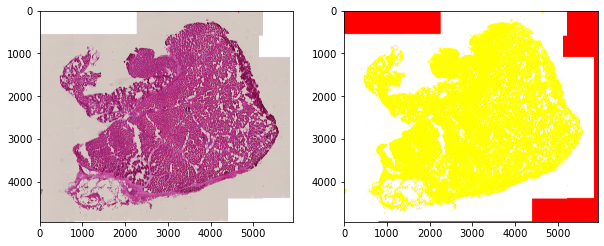

CPU times: user 5.07 s, sys: 1.69 s, total: 6.75 s
Wall time: 6.75 s


In [24]:
%%time

idx = 0

plot_img(imgs_original[idx], imgs_lab[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


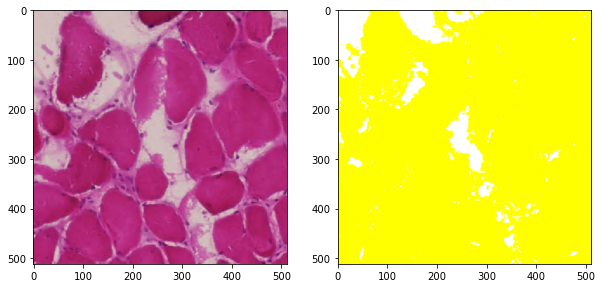

CPU times: user 8.91 s, sys: 1.81 s, total: 10.7 s
Wall time: 10.7 s


In [16]:
%%time

imgs_original_cutout = [io.imread(path) for path in rnd_original_cutout]
imgs_lab_cutout = [color.rgb2lab(img) for img in imgs_original_cutout]

idx = 0

plot_img(imgs_original_cutout[idx], imgs_lab_cutout[idx])

# (3) Convert from RGB to LAB, reshape the images to format (x*y, 3) and concatenate them in one array in one step to save memory

Number of all collected pixel-values for whole images: 2.480.703.127 (2 mrd.) <br>
Number of all collected pixel-values for cut-out images: 427.032.576 (400 mil.) /5x

In [7]:
# convert from RGB to LAB, reshape the images to format (x*y, 3) and concatenate them in one array in one step to save memory
arr_lab_flatten = []

for i, img in enumerate(imgs_original):
    
    img_tmp = color.rgb2lab(img)
    arr_tmp = img_tmp.reshape(-1, img_tmp.shape[-1])
    arr_tmp = arr_tmp.astype(np.float32)
    
    arr_lab_flatten.extend(arr_tmp)
    
    if i % 50 == 0:
        print(f'Accomplished sample: [{i} / {len(imgs_original)-1}] with image-shape: {img_tmp.shape} - num-channel: {img_tmp.shape[-1]} - array-type: {arr_tmp.dtype} - length of array collection: {len(arr_lab_flatten)}')    

Accomplished sample: [0 / 1628] with image-shape: (512, 512, 3) - num-channel: 3 - array-type: float32 - length of array collection: 262144
Accomplished sample: [50 / 1628] with image-shape: (512, 512, 3) - num-channel: 3 - array-type: float32 - length of array collection: 13369344
Accomplished sample: [100 / 1628] with image-shape: (512, 512, 3) - num-channel: 3 - array-type: float32 - length of array collection: 26476544
Accomplished sample: [150 / 1628] with image-shape: (512, 512, 3) - num-channel: 3 - array-type: float32 - length of array collection: 39583744
Accomplished sample: [200 / 1628] with image-shape: (512, 512, 3) - num-channel: 3 - array-type: float32 - length of array collection: 52690944
Accomplished sample: [250 / 1628] with image-shape: (512, 512, 3) - num-channel: 3 - array-type: float32 - length of array collection: 65798144
Accomplished sample: [300 / 1628] with image-shape: (512, 512, 3) - num-channel: 3 - array-type: float32 - length of array collection: 789053

In [18]:
# convert from RGB to LAB, reshape the images to format (x*y, 3) and concatenate them in one array in one step to save memory
arr_lab_flatten_cutout = []

for i, path in enumerate(rnd_original_cutout):
    
    img_tmp = io.imread(path)
    img_tmp = color.rgb2lab(img_tmp)
    arr_tmp = img_tmp.reshape(-1, img_tmp.shape[-1])
    arr_tmp = arr_tmp.astype(np.float32)
    
    arr_lab_flatten_cutout.extend(arr_tmp)
    
    print(f'Accomplished sample: [{i} / {len(rnd_original_cutout)-1}] with image-shape: {img_tmp.shape} - num-channel: {img_tmp.shape[-1]} - array-type: {arr_tmp.dtype} - length of array collection: {len(arr_lab_flatten_cutout)}')    

Accomplished sample: [0 / 9] with image-shape: (512, 512, 3) - num-channel: 3 - array-type: float32 - length of array collection: 262144
Accomplished sample: [1 / 9] with image-shape: (512, 512, 3) - num-channel: 3 - array-type: float32 - length of array collection: 524288
Accomplished sample: [2 / 9] with image-shape: (512, 512, 3) - num-channel: 3 - array-type: float32 - length of array collection: 786432
Accomplished sample: [3 / 9] with image-shape: (512, 512, 3) - num-channel: 3 - array-type: float32 - length of array collection: 1048576
Accomplished sample: [4 / 9] with image-shape: (512, 512, 3) - num-channel: 3 - array-type: float32 - length of array collection: 1310720
Accomplished sample: [5 / 9] with image-shape: (512, 512, 3) - num-channel: 3 - array-type: float32 - length of array collection: 1572864
Accomplished sample: [6 / 9] with image-shape: (512, 512, 3) - num-channel: 3 - array-type: float32 - length of array collection: 1835008
Accomplished sample: [7 / 9] with ima

# (4) Perform the k-means clustering on the random cut-out images to get the initialization-centers

In [42]:
number_clusters_cut_out = 3

In [43]:
%%time

kmeans_cutout = KMeans(n_clusters=number_clusters_cut_out)
kmeans_cutout.fit(arr_lab_flatten_cutout)

print(kmeans_cutout.labels_, len(kmeans_cutout.labels_))
kmeans_cutout.cluster_centers_

CPU times: user 15min 49s, sys: 1min 13s, total: 17min 2s
Wall time: 15.6 s


array([[ 79.15012405,   7.40237975,   2.99587954],
       [ 37.95744684,  55.76114799,  -7.75606161],
       [ 61.00461018,  36.24284601, -11.10606014]])

In [21]:
myinit = kmeans_cutout.cluster_centers_ + np.random.normal(0, 2)
myinit

array([[ 78.11497179,   5.90330813,   1.93818451],
       [ 33.61496802,  53.38005403,  -4.4341589 ],
       [ 62.08269847,  31.56794412, -10.76258893],
       [ 41.72695166,  55.56367553, -15.28130996]])

In [22]:
%time KMeans(n_clusters=number_clusters_cut_out, init=myinit).fit(arr_lab_flatten_cutout)

/home/jpraetor/anaconda3/envs/dltoolbox/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


CPU times: user 26.2 s, sys: 1.91 s, total: 28.2 s
Wall time: 2.34 s


KMeans(init=array([[ 78.11497179,   5.90330813,   1.93818451],
       [ 33.61496802,  53.38005403,  -4.4341589 ],
       [ 62.08269847,  31.56794412, -10.76258893],
       [ 41.72695166,  55.56367553, -15.28130996]]),
       n_clusters=4)

In [44]:
df_cluster_center_cut_out = pd.DataFrame(kmeans_cutout.cluster_centers_, columns=["L*", "a*", "b*"])
df_cluster_center_cut_out.index.name = 'Cluster'

df_cluster_center_cut_out.to_csv("cluster_centers_cutout_K_{0}.csv".format(number_clusters_cut_out))
df_cluster_center_cut_out

,L*,a*,b*
Cluster,,,
0,79.150124,7.402380,2.995880
1,37.957447,55.761148,-7.756062
2,61.004610,36.242846,-11.106060


In [51]:
# OR: load the centers
df_cluster_center_cut_out = pd.read_csv("./data/prediction/H&E/kmeans-clustering/C=3/cluster_centers_K_3.csv", index_col=0)
df_cluster_center_cut_out

,L*,a*,b*
Cluster,,,
0,80.658496,7.061353,2.360295
1,40.345774,57.396134,-10.750834
2,61.442454,38.340907,-12.740432


In [52]:
kmeans_cutout_cluster_centers = df_cluster_center_cut_out.to_numpy()
kmeans_cutout_cluster_centers

array([[ 80.6584957 ,   7.0613525 ,   2.36029482],
       [ 40.34577448,  57.3961337 , -10.7508335 ],
       [ 61.44245366,  38.34090679, -12.74043225]])

# (5) Perform the k-means clustering on the big images with the previous analyzed initialization-centers

## Cluster-table have to be in the format for K=2:<br>

| Cluster | L*     | a*     | b* |
| ---- | ---- | ---- | ---- |
| 0     | 25654     | 125     | 234 |
| 1     | 33563     | -2456     | -123 |

In [53]:
number_clusters = 3
max_iterations = 10

In [54]:
%%time

kmeans = KMeans(n_clusters=number_clusters, init=kmeans_cutout_cluster_centers, max_iter=max_iterations, verbose=1)
kmeans.fit(arr_lab_flatten)

#print(kmeans.labels_, len(kmeans.labels_))
kmeans.cluster_centers_

/home/jpraetor/anaconda3/envs/dltoolbox/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


Initialization complete
Iteration 0, inertia 56315961116.20732
Converged at iteration 0: center shift 0.002362378958600199 within tolerance 0.028987022581724035.
CPU times: user 10min 31s, sys: 30.4 s, total: 11min 1s
Wall time: 6min 15s


array([[ 80.66136887,   7.05683519,   2.36231563],
       [ 40.35033865,  57.39468583, -10.75335838],
       [ 61.46228915,  38.30088348, -12.72296744]])

In [49]:
df_cluster_center = pd.DataFrame(kmeans.cluster_centers_, columns=["L*", "a*", "b*"])
df_cluster_center.index.name = 'Cluster'

df_cluster_center.to_csv("cluster_centers_K_{0}.csv".format(number_clusters))
df_cluster_center

,L*,a*,b*
Cluster,,,
0,80.658496,7.061353,2.360295
1,40.345774,57.396134,-10.750834
2,61.442454,38.340907,-12.740432


## (5.1) Test with MiniBatchKMeans

In [46]:
%%time

minibatchkmeans = MiniBatchKMeans(n_clusters=number_clusters, init=kmeans_cutout.cluster_centers_, max_iter=max_iterations, batch_size=2048, verbose=1)
minibatchkmeans.fit(arr_lab_flatten)

#print(kmeans.labels_, len(kmeans.labels_))
minibatchkmeans.cluster_centers_

/home/jpraetor/anaconda3/envs/dltoolbox/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1600: RuntimeWarning: Explicit initial center position passed: performing only one init in MiniBatchKMeans instead of n_init=3.
  super()._check_params(X)


Init 1/1 with method: [[ 79.15012405   7.40237975   2.99587954]
 [ 37.95744684  55.76114799  -7.75606161]
 [ 61.00461018  36.24284601 -11.10606014]]
Inertia for init 1/1: 791141.562490
Minibatch iteration 1/20851200: mean batch inertia: 129.658668, ewa inertia: 129.658668 
Minibatch iteration 2/20851200: mean batch inertia: 131.461683, ewa inertia: 129.658685 
Minibatch iteration 3/20851200: mean batch inertia: 135.035590, ewa inertia: 129.658737 
Minibatch iteration 4/20851200: mean batch inertia: 129.900086, ewa inertia: 129.658739 
Minibatch iteration 5/20851200: mean batch inertia: 131.035363, ewa inertia: 129.658752 
Minibatch iteration 6/20851200: mean batch inertia: 133.929775, ewa inertia: 129.658793 
Minibatch iteration 7/20851200: mean batch inertia: 129.164564, ewa inertia: 129.658788 
Minibatch iteration 8/20851200: mean batch inertia: 136.944066, ewa inertia: 129.658858 
Minibatch iteration 9/20851200: mean batch inertia: 125.896753, ewa inertia: 129.658822 
Minibatch iter

array([[ 80.73383088,   7.04561978,   2.36479449],
       [ 40.36388823,  57.38926445, -10.74251569],
       [ 61.29184432,  38.4309858 , -12.70041102]])

In [47]:
df_cluster_center_minibatch = pd.DataFrame(minibatchkmeans.cluster_centers_, columns=["L*", "a*", "b*"])
df_cluster_center_minibatch.index.name = 'Cluster'

df_cluster_center_minibatch.to_csv("cluster_centers_minibatch_K_{0}.csv".format(number_clusters))
df_cluster_center_minibatch

,L*,a*,b*
Cluster,,,
0,80.733831,7.045620,2.364794
1,40.363888,57.389264,-10.742516
2,61.291844,38.430986,-12.700411


# (6) Predict specified images

In [ ]:
number_clusters = 3

In [55]:
save_path = "./data/prediction/kmeans-clustering/C=3/predictions/"

In [64]:
# load k-means center
all_kmeans = glob(f'./data/prediction/kmeans-clustering/C=3/*.csv')
all_kmeans

['/asbdata/Philipp/SheepFat/prediction/LAB_kmeans/C=4/cluster_centers_K_4.csv',
 '/asbdata/Philipp/SheepFat/prediction/LAB_kmeans/C=4/cluster_centers_cutout_K_4.csv',
 '/asbdata/Philipp/SheepFat/prediction/LAB_kmeans/C=4/cluster_centers_minibatch_K_4.csv']

In [65]:
path_means = all_kmeans[0]
print(path_means)

df_kmeans = pd.read_csv(path_means, index_col=0)
df_kmeans

/asbdata/Philipp/SheepFat/prediction/LAB_kmeans/C=4/cluster_centers_K_4.csv


,L*,a*,b*
Cluster,,,
0,81.024203,6.493488,2.637092
1,36.326309,55.713999,-6.826536
2,63.915660,33.472404,-10.502167
3,47.630440,59.254783,-17.174961


In [66]:
arr_kmeans = df_kmeans.to_numpy()
arr_kmeans

array([[ 81.02420279,   6.49348818,   2.63709231],
       [ 36.32630858,  55.71399885,  -6.82653592],
       [ 63.91566004,  33.47240387, -10.50216714],
       [ 47.6304403 ,  59.25478266, -17.17496082]])

In [69]:
%%time

kmeans = KMeans(n_clusters=number_clusters, init=arr_kmeans, verbose=1)
kmeans

CPU times: user 31 µs, sys: 3 µs, total: 34 µs
Wall time: 43.2 µs


KMeans(init=array([[ 81.02420279,   6.49348818,   2.63709231],
       [ 36.32630858,  55.71399885,  -6.82653592],
       [ 63.91566004,  33.47240387, -10.50216714],
       [ 47.6304403 ,  59.25478266, -17.17496082]]),
       n_clusters=4, verbose=1)

## Load and predict the images

In [17]:
# original tissue
all_original = glob('./data/images/KW/H&E/inputs/*.tif')

# original patches
# all_original = glob('./data/images/KW/H&E/subwindows_512x512/original/*.tif')

#print(*[x.split('/')[-1] for x in np.sort(all_original)], sep='\n')  
len(all_original)

17

In [ ]:
# convert from RGB to LAB, reshape the images to format (x*y, 3) and concatenate them in one array in one step to save memory
imgs_predict = []

for i, path in enumerate(all_original):
    
    img_tmp = io.imread(path)
    img_tmp = color.rgb2lab(img_tmp)    
    img_shape = img_tmp.shape
    
    Y = img_tmp.reshape(-1, img_tmp.shape[-1])
        
    # predict all LAB-pixel-intensities
    arr_y = kmeans.predict(Y)
   
    # reshape the arry back to its image format
    img_pred = arr_y.reshape(img_shape[0], img_shape[1])
    
    # save image
    filepath = os.path.splitext(os.path.basename(path))[0] + ".png"
    filepath = os.path.join(save_path, filepath)
    
    io.imsave(filepath, img_pred, check_contrast=True)

    if i % 50 == 0:
        print(f'Accomplished sample: [{i} / {len(all_original)-1}] with image-shape: {img_shape} - array-type: {Y.dtype} - length of prediciton: {arr_y.shape} - unique predicitons: {np.unique(arr_y)} - img-pred-shape: {img_pred.shape} - filepath: {filepath}')    
        
    #plot_img(imgs_original[0], img_pred)

# Build and train a k-means clustering with externals scripts

In [84]:
model_id = "TEST"

In [87]:
model_config = {
    "n_classes": 3,
    "max_epochs": 10,
    "input_dir": "./data/images/KW/H&E/subwindows_512x512/original/*S50*",   
    "output_model_path": f"./model/kmeans/KW/{model_id}/cluster_center.csv",
}

In [88]:
%%time

model = kmeans_clustering.build_and_fit_model(config=model_config)

[build_and_fit_model] Read images from path: ./data/images/KW/H&E/subwindows_512x512/original/*S50*
[build_and_fit_model] Read images: 121
[build_and_fit_model] Convert images to LAB color space: 121
[build_and_fit_model] Flatten color images to shape: (512, 512, 3)
[build_and_fit_model] Start clustering with vector: (31719424, 3)
Initialization complete
Iteration 0, inertia 5475283456.0
Iteration 1, inertia 4359634944.0
Iteration 2, inertia 4291540736.0
Iteration 3, inertia 4254990592.0
Iteration 4, inertia 4220588288.0
Iteration 5, inertia 4180747264.0
Iteration 6, inertia 4119240704.0
Iteration 7, inertia 4007227904.0
Iteration 8, inertia 3857108480.0
Iteration 9, inertia 3734490368.0
Initialization complete
Iteration 0, inertia 5149789696.0
Iteration 1, inertia 3725448192.0
Iteration 2, inertia 3625200896.0
Iteration 3, inertia 3580950528.0
Iteration 4, inertia 3560601088.0
Iteration 5, inertia 3551321856.0
Iteration 6, inertia 3546411520.0
Iteration 7, inertia 3544860160.0
Iterati

# Predict on all specified samples

In [89]:
config = {
    "input_dir": "./data/images/KW/H&E/subwindows_512x512/original/*S50*",   
    "output_dir": f"./model/kmeans/KW/{model_id}/",
}

In [90]:
%%time

kmeans_clustering.predict_samples(config=config, model=model)

Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.


[predict_samples] Found paths to images: 121


Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.


Accomplished sample: [0 / 120] image with shape: (512, 512) to filename: ./model/kmeans/KW/TEST/0164_S50.4_SHAM_H&E_10x_walluks.png


Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert imag

Accomplished sample: [10 / 120] image with shape: (512, 512) to filename: ./model/kmeans/KW/TEST/0159_S50.4_SHAM_H&E_10x_walluks.png


Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert imag

Accomplished sample: [20 / 120] image with shape: (512, 512) to filename: ./model/kmeans/KW/TEST/0106_S50.4_SHAM_H&E_10x_walluks.png


Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert imag

Accomplished sample: [30 / 120] image with shape: (512, 512) to filename: ./model/kmeans/KW/TEST/0148_S50.4_SHAM_H&E_10x_walluks.png


Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert imag

Accomplished sample: [40 / 120] image with shape: (512, 512) to filename: ./model/kmeans/KW/TEST/0060_S50.4_SHAM_H&E_10x_walluks.png


Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert imag

Accomplished sample: [50 / 120] image with shape: (512, 512) to filename: ./model/kmeans/KW/TEST/0097_S50.4_SHAM_H&E_10x_walluks.png


Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert imag

Accomplished sample: [60 / 120] image with shape: (512, 512) to filename: ./model/kmeans/KW/TEST/0092_S50.4_SHAM_H&E_10x_walluks.png


Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert imag

Accomplished sample: [70 / 120] image with shape: (512, 512) to filename: ./model/kmeans/KW/TEST/0112_S50.4_SHAM_H&E_10x_walluks.png


Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert imag

Accomplished sample: [80 / 120] image with shape: (512, 512) to filename: ./model/kmeans/KW/TEST/0086_S50.4_SHAM_H&E_10x_walluks.png


Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert imag

Accomplished sample: [90 / 120] image with shape: (512, 512) to filename: ./model/kmeans/KW/TEST/0156_S50.4_SHAM_H&E_10x_walluks.png


Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert imag

Accomplished sample: [100 / 120] image with shape: (512, 512) to filename: ./model/kmeans/KW/TEST/0089_S50.4_SHAM_H&E_10x_walluks.png


Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert imag

Accomplished sample: [110 / 120] image with shape: (512, 512) to filename: ./model/kmeans/KW/TEST/0069_S50.4_SHAM_H&E_10x_walluks.png


Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 2]. Convert imag

Accomplished sample: [120 / 120] image with shape: (512, 512) to filename: ./model/kmeans/KW/TEST/0143_S50.4_SHAM_H&E_10x_walluks.png
CPU times: user 1h 30min 25s, sys: 2min 42s, total: 1h 33min 7s
Wall time: 23.1 s
